In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
zip_path = '/content/drive/MyDrive/cv_data/hw4_release_dataset.zip'
extract_path = '/content/hw4_dataset'

import zipfile
import os

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset 解壓縮完成！資料夾位置：{extract_path}")


Dataset 解壓縮完成！資料夾位置：/content/hw4_dataset


Dataset size: 3200


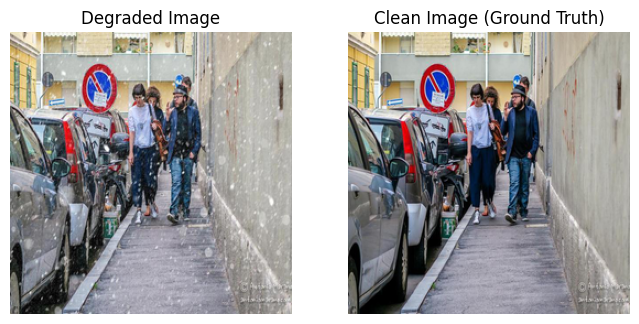

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class HW4ImageRestorationDataset(Dataset):
    def __init__(self, degraded_dir, clean_dir, transform=None):
        self.degraded_dir = degraded_dir
        self.clean_dir = clean_dir
        self.filenames = sorted([f for f in os.listdir(degraded_dir)
                                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform if transform else T.ToTensor()  # default ToTensor()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        degraded_path = os.path.join(self.degraded_dir, self.filenames[idx])
        clean_name = self.filenames[idx]
        if 'rain' in clean_name:
            clean_name = clean_name.replace('.png', '').replace('rain-', 'rain_clean-') + '.png'
        elif 'snow' in clean_name:
            clean_name = clean_name.replace('.png', '').replace('snow-', 'snow_clean-') + '.png'
        else:
            raise ValueError("Unknown filename format: " + clean_name)

        clean_path = os.path.join(self.clean_dir, clean_name)

        degraded_img = Image.open(degraded_path).convert("RGB")
        clean_img = Image.open(clean_path).convert("RGB")

        degraded_img = self.transform(degraded_img)
        clean_img = self.transform(clean_img)

        return degraded_img, clean_img


# Visaulize
dataset_path = '/content/hw4_dataset/train'
degraded_dir = os.path.join(dataset_path, 'degraded')
clean_dir = os.path.join(dataset_path, 'clean')

dataset = HW4ImageRestorationDataset(degraded_dir, clean_dir)
print(f"Dataset size: {len(dataset)}")


degraded_img, clean_img = dataset[1600]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(degraded_img.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
axs[0].set_title("Degraded Image")
axs[0].axis('off')

axs[1].imshow(clean_img.permute(1, 2, 0))
axs[1].set_title("Clean Image (Ground Truth)")
axs[1].axis('off')

plt.show()


In [3]:
from sklearn.model_selection import train_test_split

dataset_path = '/content/hw4_dataset/train'
degraded_dir = os.path.join(dataset_path, 'degraded')
clean_dir = os.path.join(dataset_path, 'clean')

def get_file_list(degraded_dir):
    return sorted([f for f in os.listdir(degraded_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# spilt train / val
all_files = get_file_list(degraded_dir)
train_files, val_files = train_test_split(all_files, test_size=0.1, random_state=42)  # 90% train, 10% val

class HW4SplitDataset(Dataset):
    def __init__(self, degraded_dir, clean_dir, file_list, transform=None):
        self.degraded_dir = degraded_dir
        self.clean_dir = clean_dir
        self.file_list = file_list
        self.transform = transform if transform else T.ToTensor()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        degraded_path = os.path.join(self.degraded_dir, filename)

        if 'rain' in filename:
            clean_name = filename.replace('.png', '').replace('rain-', 'rain_clean-') + '.png'
        elif 'snow' in filename:
            clean_name = filename.replace('.png', '').replace('snow-', 'snow_clean-') + '.png'
        else:
            raise ValueError("Unknown filename format: " + filename)

        clean_path = os.path.join(self.clean_dir, clean_name)

        degraded_img = Image.open(degraded_path).convert("RGB")
        clean_img = Image.open(clean_path).convert("RGB")

        degraded_img = self.transform(degraded_img)
        clean_img = self.transform(clean_img)

        return degraded_img, clean_img

# Set Dataset
train_dataset = HW4SplitDataset(degraded_dir, clean_dir, train_files)
val_dataset = HW4SplitDataset(degraded_dir, clean_dir, val_files)

# Set Dataloader
from torch.utils.data import DataLoader

BATCH_SIZE = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train set: {len(train_dataset)}, Val set: {len(val_dataset)}")

# Visaulize
degraded_img, clean_img = train_dataset[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(degraded_img.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
axs[0].set_title("Degraded Image")
axs[0].axis('off')

axs[1].imshow(clean_img.permute(1, 2, 0))
axs[1].set_title("Clean Image (Ground Truth)")
axs[1].axis('off')

plt.show()

Train set: 2880, Val set: 320


In [4]:
!cp "/content/drive/MyDrive/cv_data/model_swinir.py" .

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model_swinir import SwinIR

class PromptBlock(nn.Module):
    def __init__(self, channels, prompt_dim=32):
        super().__init__()
        self.prompt = nn.Sequential(
            nn.Conv2d(channels, prompt_dim, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(prompt_dim, channels, kernel_size=1)
        )

    def forward(self, x):
        residual = x
        out = self.prompt(x)
        return residual + out

class PromptIR_Improved(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=96, prompt_dim=32):
        super().__init__()
        # Replace encoder-decoder with SwinIR backbone
        self.swinir = SwinIR(
            upscale=1,  # no super-resolution
            in_chans=in_channels,
            img_size=64,
            window_size=8,
            img_range=1.0,
            depths=[6, 6, 6, 6],
            embed_dim=96,
            num_heads=[6, 6, 6, 6],
            mlp_ratio=2,
            upsampler='',
            resi_connection='1conv'
        )
        # Optional prompt block after SwinIR
        self.prompt = PromptBlock(3, prompt_dim)

    def forward(self, x, targets=None, criterion=None):
        out_main = self.swinir(x)
        out_main = self.prompt(out_main)
        if self.training and targets is not None and criterion is not None:
            loss = criterion(out_main, targets)
            return out_main, loss
        return out_main


In [6]:
def calculate_psnr(pred, target, max_pixel=1.0):
    mse = torch.mean((pred - target) ** 2, dim=[1,2,3])
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse + 1e-8))
    return psnr.mean().item()


In [17]:
class CharbonnierLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(CharbonnierLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, prediction, target):
        diff = prediction - target
        loss = torch.mean(torch.sqrt(diff * diff + self.epsilon))
        return loss

In [18]:
from tqdm import tqdm
import torch.optim as optim

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    loop = tqdm(dataloader, desc='Training', leave=False)
    for degraded, clean in loop:
        degraded, clean = degraded.to(device), clean.to(device)
        optimizer.zero_grad()
        outputs = model(degraded)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * degraded.size(0)
        loop.set_postfix(loss=loss.item())
    return running_loss / len(dataloader.dataset)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_psnr = 0.0
    loop = tqdm(dataloader, desc='Validation', leave=False)
    with torch.no_grad():
        for degraded, clean in loop:
            degraded, clean = degraded.to(device), clean.to(device)
            outputs = model(degraded)
            loss = criterion(outputs, clean)
            running_loss += loss.item() * degraded.size(0)
            psnr = calculate_psnr(outputs, clean)
            total_psnr += psnr * degraded.size(0)
            loop.set_postfix(loss=loss.item(), psnr=psnr)
    avg_loss = running_loss / len(dataloader.dataset)
    avg_psnr = total_psnr / len(dataloader.dataset)
    return avg_loss, avg_psnr


In [19]:
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PromptIR_Improved().to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50)  # 假設訓練50 epoch
criterion = CharbonnierLoss()

EPOCHS = 50
best_psnr = 0.0
epochs_no_improve = 0
early_stop_patience = 5

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_psnr = validate(model, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val PSNR: {val_psnr:.2f} dB")

    # save best model
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save(model.state_dict(), "best_promptir_baseline.pth")
        print(f"✅ Best model updated! Val PSNR: {val_psnr:.2f} dB")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epochs.")

    # early stopping
    if epochs_no_improve >= early_stop_patience:
        print(f"⏹️ Early stopping triggered after {epoch+1} epochs (no improvement for {early_stop_patience} epochs).")
        break


Epoch [1/50] | Train Loss: 0.1048 | Val Loss: 0.0787 | Val PSNR: 20.15 dB
✅ Best model updated! Val PSNR: 20.15 dB


Epoch [2/50] | Train Loss: 0.0762 | Val Loss: 0.0758 | Val PSNR: 20.52 dB
✅ Best model updated! Val PSNR: 20.52 dB


Epoch [3/50] | Train Loss: 0.0692 | Val Loss: 0.0654 | Val PSNR: 21.35 dB
✅ Best model updated! Val PSNR: 21.35 dB


Epoch [4/50] | Train Loss: 0.0665 | Val Loss: 0.0584 | Val PSNR: 22.34 dB
✅ Best model updated! Val PSNR: 22.34 dB


Epoch [5/50] | Train Loss: 0.0613 | Val Loss: 0.0594 | Val PSNR: 22.29 dB
⚠️ No improvement for 1 epochs.


Epoch [6/50] | Train Loss: 0.0594 | Val Loss: 0.0642 | Val PSNR: 21.90 dB
⚠️ No improvement for 2 epochs.


Epoch [7/50] | Train Loss: 0.0562 | Val Loss: 0.0534 | Val PSNR: 23.13 dB
✅ Best model updated! Val PSNR: 23.13 dB


Epoch [8/50] | Train Loss: 0.0547 | Val Loss: 0.0565 | Val PSNR: 22.83 dB
⚠️ No improvement for 1 epochs.


Epoch [9/50] | Train Loss: 0.0527 | Val Loss: 0.0565 | Val PSNR: 22.92 dB
⚠️ No improvement for 2 epochs.


Epoch [10/50] | Train Loss: 0.0518 | Val Loss: 0.0514 | Val PSNR: 23.64 dB
✅ Best model updated! Val PSNR: 23.64 dB


Epoch [11/50] | Train Loss: 0.0501 | Val Loss: 0.0492 | Val PSNR: 23.88 dB
✅ Best model updated! Val PSNR: 23.88 dB


Epoch [12/50] | Train Loss: 0.0491 | Val Loss: 0.0457 | Val PSNR: 24.29 dB
✅ Best model updated! Val PSNR: 24.29 dB


Epoch [13/50] | Train Loss: 0.0481 | Val Loss: 0.0444 | Val PSNR: 24.57 dB
✅ Best model updated! Val PSNR: 24.57 dB


Epoch [14/50] | Train Loss: 0.0481 | Val Loss: 0.0464 | Val PSNR: 24.25 dB
⚠️ No improvement for 1 epochs.


Epoch [15/50] | Train Loss: 0.0465 | Val Loss: 0.0481 | Val PSNR: 24.03 dB
⚠️ No improvement for 2 epochs.


Epoch [16/50] | Train Loss: 0.0457 | Val Loss: 0.0474 | Val PSNR: 24.24 dB
⚠️ No improvement for 3 epochs.


Epoch [17/50] | Train Loss: 0.0452 | Val Loss: 0.0457 | Val PSNR: 24.45 dB
⚠️ No improvement for 4 epochs.


Epoch [18/50] | Train Loss: 0.0446 | Val Loss: 0.0432 | Val PSNR: 24.71 dB
✅ Best model updated! Val PSNR: 24.71 dB


Epoch [19/50] | Train Loss: 0.0450 | Val Loss: 0.0441 | Val PSNR: 24.81 dB
✅ Best model updated! Val PSNR: 24.81 dB


Epoch [20/50] | Train Loss: 0.0439 | Val Loss: 0.0417 | Val PSNR: 25.02 dB
✅ Best model updated! Val PSNR: 25.02 dB


Epoch [21/50] | Train Loss: 0.0429 | Val Loss: 0.0427 | Val PSNR: 24.76 dB
⚠️ No improvement for 1 epochs.


Epoch [22/50] | Train Loss: 0.0424 | Val Loss: 0.0400 | Val PSNR: 25.33 dB
✅ Best model updated! Val PSNR: 25.33 dB


Epoch [23/50] | Train Loss: 0.0421 | Val Loss: 0.0439 | Val PSNR: 24.73 dB
⚠️ No improvement for 1 epochs.


Epoch [24/50] | Train Loss: 0.0422 | Val Loss: 0.0423 | Val PSNR: 24.96 dB
⚠️ No improvement for 2 epochs.


Epoch [25/50] | Train Loss: 0.0417 | Val Loss: 0.0401 | Val PSNR: 25.27 dB
⚠️ No improvement for 3 epochs.


Epoch [26/50] | Train Loss: 0.0405 | Val Loss: 0.0386 | Val PSNR: 25.59 dB
✅ Best model updated! Val PSNR: 25.59 dB


Epoch [27/50] | Train Loss: 0.0406 | Val Loss: 0.0423 | Val PSNR: 25.02 dB
⚠️ No improvement for 1 epochs.


Epoch [28/50] | Train Loss: 0.0399 | Val Loss: 0.0400 | Val PSNR: 25.40 dB
⚠️ No improvement for 2 epochs.


Epoch [29/50] | Train Loss: 0.0398 | Val Loss: 0.0384 | Val PSNR: 25.71 dB
✅ Best model updated! Val PSNR: 25.71 dB


Epoch [30/50] | Train Loss: 0.0393 | Val Loss: 0.0412 | Val PSNR: 25.11 dB
⚠️ No improvement for 1 epochs.


Epoch [31/50] | Train Loss: 0.0397 | Val Loss: 0.0421 | Val PSNR: 24.95 dB
⚠️ No improvement for 2 epochs.


Epoch [32/50] | Train Loss: 0.0396 | Val Loss: 0.0378 | Val PSNR: 25.76 dB
✅ Best model updated! Val PSNR: 25.76 dB


Epoch [33/50] | Train Loss: 0.0390 | Val Loss: 0.0387 | Val PSNR: 25.60 dB
⚠️ No improvement for 1 epochs.


Epoch [34/50] | Train Loss: 0.0387 | Val Loss: 0.0420 | Val PSNR: 25.20 dB
⚠️ No improvement for 2 epochs.


Epoch [35/50] | Train Loss: 0.0384 | Val Loss: 0.0402 | Val PSNR: 25.57 dB
⚠️ No improvement for 3 epochs.


Epoch [36/50] | Train Loss: 0.0385 | Val Loss: 0.0457 | Val PSNR: 24.62 dB
⚠️ No improvement for 4 epochs.


Epoch [37/50] | Train Loss: 0.0391 | Val Loss: 0.0386 | Val PSNR: 25.72 dB
⚠️ No improvement for 5 epochs.
⏹️ Early stopping triggered after 37 epochs (no improvement for 5 epochs).


In [20]:
# with TTA
import numpy as np

# --- Step 1: Define Test Dataset ---
class HW4TestDataset(Dataset):
    def __init__(self, degraded_dir, transform=None):
        self.degraded_dir = degraded_dir
        self.filenames = sorted([f for f in os.listdir(degraded_dir)
                                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform if transform else T.ToTensor()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_path = os.path.join(self.degraded_dir, filename)
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return img, filename

# --- Step 2: Define TTA Function ---
def apply_tta(model, image, device):
    model.eval()
    transforms = [
        lambda x: x,
        lambda x: torch.flip(x, dims=[-1]),         # horizontal flip
    ]
    inv_transforms = [
        lambda x: x,
        lambda x: torch.flip(x, dims=[-1]),
    ]

    preds = []
    with torch.no_grad():
        for t, inv_t in zip(transforms, inv_transforms):
            aug_img = t(image)
            out = model(aug_img.to(device))
            out = inv_t(out)
            preds.append(out.cpu())
    return torch.stack(preds).mean(0)

# --- Step 3: Predict and Save to pred.npz ---
test_dir = '/content/hw4_dataset/test/degraded'
test_dataset = HW4TestDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load model
# model = PromptIRBaseline().to(device)
# model = PromptIRv2().to(device)
model = PromptIR_Improved().to(device)
model.load_state_dict(torch.load("best_promptir_baseline.pth", map_location=device))
model.eval()

images_dict = {}

with torch.no_grad():
    for img, filename in tqdm(test_loader, desc="Predicting Test Images"):
        img = img.to(device)  # (1, 3, H, W)
        output = apply_tta(model, img, device)  # (1, 3, H, W)
        output = output.clamp(0, 1)  # clip to [0,1]
        output_np = (output.squeeze().cpu().numpy() * 255).astype(np.uint8)  # (3, H, W)
        images_dict[filename[0]] = output_np

# Save to .npz
np.savez('pred.npz', **images_dict)
print(f"✅ Saved {len(images_dict)} images to pred.npz")

# Download pred.npz
from google.colab import files
files.download('pred.npz')


Predicting Test Images: 100%|██████████| 100/100 [00:03<00:00, 31.05it/s]


✅ Saved 100 images to pred.npz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

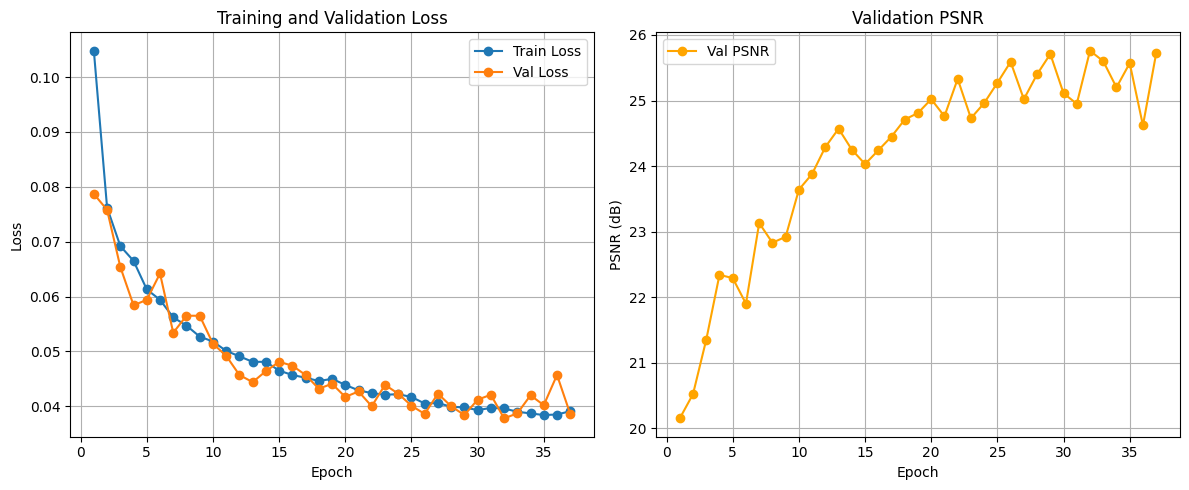

In [21]:
import re
import matplotlib.pyplot as plt

# 原始log貼在這裡
raw_log = """
Epoch [1/50] | Train Loss: 0.1048 | Val Loss: 0.0787 | Val PSNR: 20.15 dB
✅ Best model updated! Val PSNR: 20.15 dB
Epoch [2/50] | Train Loss: 0.0762 | Val Loss: 0.0758 | Val PSNR: 20.52 dB
✅ Best model updated! Val PSNR: 20.52 dB
Epoch [3/50] | Train Loss: 0.0692 | Val Loss: 0.0654 | Val PSNR: 21.35 dB
✅ Best model updated! Val PSNR: 21.35 dB
Epoch [4/50] | Train Loss: 0.0665 | Val Loss: 0.0584 | Val PSNR: 22.34 dB
✅ Best model updated! Val PSNR: 22.34 dB
Epoch [5/50] | Train Loss: 0.0613 | Val Loss: 0.0594 | Val PSNR: 22.29 dB
⚠️ No improvement for 1 epochs.
Epoch [6/50] | Train Loss: 0.0594 | Val Loss: 0.0642 | Val PSNR: 21.90 dB
⚠️ No improvement for 2 epochs.
Epoch [7/50] | Train Loss: 0.0562 | Val Loss: 0.0534 | Val PSNR: 23.13 dB
✅ Best model updated! Val PSNR: 23.13 dB
Epoch [8/50] | Train Loss: 0.0547 | Val Loss: 0.0565 | Val PSNR: 22.83 dB
⚠️ No improvement for 1 epochs.
Epoch [9/50] | Train Loss: 0.0527 | Val Loss: 0.0565 | Val PSNR: 22.92 dB
⚠️ No improvement for 2 epochs.
Epoch [10/50] | Train Loss: 0.0518 | Val Loss: 0.0514 | Val PSNR: 23.64 dB
✅ Best model updated! Val PSNR: 23.64 dB
Epoch [11/50] | Train Loss: 0.0501 | Val Loss: 0.0492 | Val PSNR: 23.88 dB
✅ Best model updated! Val PSNR: 23.88 dB
Epoch [12/50] | Train Loss: 0.0491 | Val Loss: 0.0457 | Val PSNR: 24.29 dB
✅ Best model updated! Val PSNR: 24.29 dB
Epoch [13/50] | Train Loss: 0.0481 | Val Loss: 0.0444 | Val PSNR: 24.57 dB
✅ Best model updated! Val PSNR: 24.57 dB
Epoch [14/50] | Train Loss: 0.0481 | Val Loss: 0.0464 | Val PSNR: 24.25 dB
⚠️ No improvement for 1 epochs.
Epoch [15/50] | Train Loss: 0.0465 | Val Loss: 0.0481 | Val PSNR: 24.03 dB
⚠️ No improvement for 2 epochs.
Epoch [16/50] | Train Loss: 0.0457 | Val Loss: 0.0474 | Val PSNR: 24.24 dB
⚠️ No improvement for 3 epochs.
Epoch [17/50] | Train Loss: 0.0452 | Val Loss: 0.0457 | Val PSNR: 24.45 dB
⚠️ No improvement for 4 epochs.
Epoch [18/50] | Train Loss: 0.0446 | Val Loss: 0.0432 | Val PSNR: 24.71 dB
✅ Best model updated! Val PSNR: 24.71 dB
Epoch [19/50] | Train Loss: 0.0450 | Val Loss: 0.0441 | Val PSNR: 24.81 dB
✅ Best model updated! Val PSNR: 24.81 dB
Epoch [20/50] | Train Loss: 0.0439 | Val Loss: 0.0417 | Val PSNR: 25.02 dB
✅ Best model updated! Val PSNR: 25.02 dB
Epoch [21/50] | Train Loss: 0.0429 | Val Loss: 0.0427 | Val PSNR: 24.76 dB
⚠️ No improvement for 1 epochs.
Epoch [22/50] | Train Loss: 0.0424 | Val Loss: 0.0400 | Val PSNR: 25.33 dB
✅ Best model updated! Val PSNR: 25.33 dB
Epoch [23/50] | Train Loss: 0.0421 | Val Loss: 0.0439 | Val PSNR: 24.73 dB
⚠️ No improvement for 1 epochs.
Epoch [24/50] | Train Loss: 0.0422 | Val Loss: 0.0423 | Val PSNR: 24.96 dB
⚠️ No improvement for 2 epochs.
Epoch [25/50] | Train Loss: 0.0417 | Val Loss: 0.0401 | Val PSNR: 25.27 dB
⚠️ No improvement for 3 epochs.
Epoch [26/50] | Train Loss: 0.0405 | Val Loss: 0.0386 | Val PSNR: 25.59 dB
✅ Best model updated! Val PSNR: 25.59 dB
Epoch [27/50] | Train Loss: 0.0406 | Val Loss: 0.0423 | Val PSNR: 25.02 dB
⚠️ No improvement for 1 epochs.
Epoch [28/50] | Train Loss: 0.0399 | Val Loss: 0.0400 | Val PSNR: 25.40 dB
⚠️ No improvement for 2 epochs.
Epoch [29/50] | Train Loss: 0.0398 | Val Loss: 0.0384 | Val PSNR: 25.71 dB
✅ Best model updated! Val PSNR: 25.71 dB
Epoch [30/50] | Train Loss: 0.0393 | Val Loss: 0.0412 | Val PSNR: 25.11 dB
⚠️ No improvement for 1 epochs.
Epoch [31/50] | Train Loss: 0.0397 | Val Loss: 0.0421 | Val PSNR: 24.95 dB
⚠️ No improvement for 2 epochs.
Epoch [32/50] | Train Loss: 0.0396 | Val Loss: 0.0378 | Val PSNR: 25.76 dB
✅ Best model updated! Val PSNR: 25.76 dB
Epoch [33/50] | Train Loss: 0.0390 | Val Loss: 0.0387 | Val PSNR: 25.60 dB
⚠️ No improvement for 1 epochs.
Epoch [34/50] | Train Loss: 0.0387 | Val Loss: 0.0420 | Val PSNR: 25.20 dB
⚠️ No improvement for 2 epochs.
Epoch [35/50] | Train Loss: 0.0384 | Val Loss: 0.0402 | Val PSNR: 25.57 dB
⚠️ No improvement for 3 epochs.
Epoch [36/50] | Train Loss: 0.0385 | Val Loss: 0.0457 | Val PSNR: 24.62 dB
⚠️ No improvement for 4 epochs.
Epoch [37/50] | Train Loss: 0.0391 | Val Loss: 0.0386 | Val PSNR: 25.72 dB
⚠️ No improvement for 5 epochs.
⏹️ Early stopping triggered after 37 epochs (no improvement for 5 epochs).

"""

# 正則表達式提取數據
pattern = r"Epoch \[(\d+)/\d+\] \| Train Loss: ([\d.]+) \| Val Loss: ([\d.]+) \| Val PSNR: ([\d.]+) dB"
matches = re.findall(pattern, raw_log)

epochs = [int(m[0]) for m in matches]
train_losses = [float(m[1]) for m in matches]
val_losses = [float(m[2]) for m in matches]
val_psnrs = [float(m[3]) for m in matches]

# 畫圖
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_psnrs, label='Val PSNR', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Total test images: 100


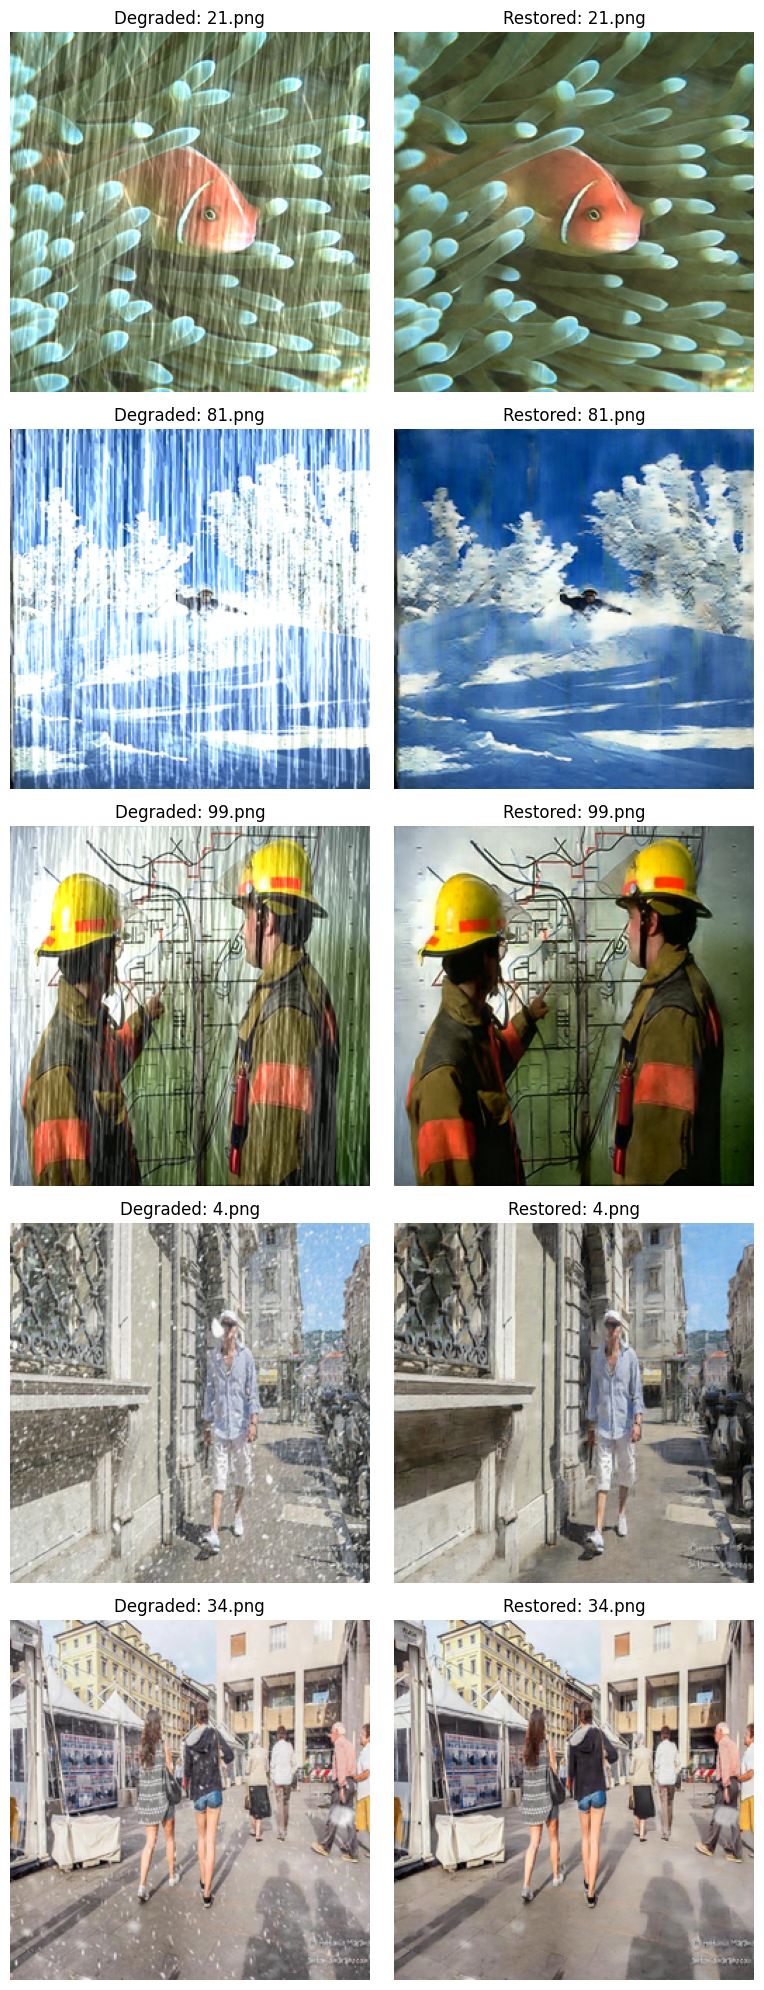

In [22]:
import random

# 設定資料夾路徑
test_degraded_dir = '/content/hw4_dataset/test/degraded'
pred_file = 'pred.npz'

# 載入 pred.npz
pred_data = np.load(pred_file)
pred_keys = pred_data.files

print(f"Total test images: {len(pred_keys)}")

# 隨機選5張
sample_keys = random.sample(pred_keys, 5)

# 顯示每張的 degraded + restored
fig, axs = plt.subplots(5, 2, figsize=(8, 20))
for i, key in enumerate(sample_keys):
    # ⭐️ Degraded image
    degraded_path = os.path.join(test_degraded_dir, key)
    degraded_img = Image.open(degraded_path).convert('RGB')
    degraded_img = np.array(degraded_img)

    # ⭐️ Restored image
    restored_img = pred_data[key]  # (3, H, W)
    restored_img = np.transpose(restored_img, (1, 2, 0))  # → (H, W, 3)

    # 顯示
    axs[i, 0].imshow(degraded_img)
    axs[i, 0].set_title(f"Degraded: {key}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(restored_img)
    axs[i, 1].set_title(f"Restored: {key}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()
